# NDVI Phenology
<hr>
# Notebook Summary

* LANDSAT 7 and LANDSAT 8 are used to detect changes in plant life over time.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines.

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Retrieve the data from the datacube](#retrieve_data_time_series)
* [Obtain the clean mask](#obtain_clean_mask_time_series)
* [Filter out clouds, scan lines, and invalid data](#clean_mask_time_series)
* [Calculate NDVI](#calculate)
* [Plot a time series analysis](#time_series_analysis)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from dc_notebook_utilities import generate_metadata_report
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime as dt
from utils.data_cube_utilities.dc_ndvi import NDVI
import utils.data_cube_utilities.plotter_utils as plotter

# Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
print(products_info[["platform", "name"]]
      [products_info.platform == "LANDSAT_7"])
print()

# List LANDSAT 8 products
print("LANDSAT 8 Products:")
print(products_info[["platform", "name"]]
      [products_info.platform == "LANDSAT_8"])

LANDSAT 7 Products:
     platform                           name
id                                          
8   LANDSAT_7       ls7_collections_sr_scene
70  LANDSAT_7  ls7_collections_sr_scene_lean
19  LANDSAT_7        ls7_ledaps_amazon_river
20  LANDSAT_7          ls7_ledaps_bangladesh
35  LANDSAT_7     ls7_ledaps_bangladesh_bari
36  LANDSAT_7             ls7_ledaps_caqueta
21  LANDSAT_7            ls7_ledaps_colombia
22  LANDSAT_7               ls7_ledaps_ghana
23  LANDSAT_7               ls7_ledaps_kenya
41  LANDSAT_7        ls7_ledaps_lake_baringo
24  LANDSAT_7      ls7_ledaps_lake_chad_full
25  LANDSAT_7        ls7_ledaps_lake_cortijo
26  LANDSAT_7      ls7_ledaps_menindee_lakes
27  LANDSAT_7          ls7_ledaps_meta_river
62  LANDSAT_7              ls7_ledaps_mexico
28  LANDSAT_7     ls7_ledaps_salgar_colombia
72  LANDSAT_7          ls7_ledaps_sanagustin
63  LANDSAT_7               ls7_ledaps_scene
29  LANDSAT_7                ls7_ledaps_togo
30  LANDSAT_7               ls7_led

In [3]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration. Only select one LANDSAT 7 product, 
# one LANDSAT 8 product, or one of both. The products must have similar areas.
platforms = ["LANDSAT_7", "LANDSAT_8"] # Must be list            
products = ["ls7_ledaps_vietnam", "ls8_lasrc_vietnam"] # Must be list   

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [4]:
descriptors = np.empty(len(platforms), dtype=object)
lat_lons = np.empty((len(platforms), 2))
min_max_dates = np.empty((len(platforms), 2), dtype=object)
min_max_lat = np.empty((len(platforms), 2))
min_max_lon = np.empty((len(platforms), 2))
min_max_date_strs = np.empty((len(platforms), 2), dtype=object)
min_lat_lon_rounded = np.empty((len(platforms), 2))
max_lat_lon_rounded = np.empty((len(platforms), 2))
for i, (platform, product) in enumerate(zip(platforms, products)):
    # Get the extents of the cube
    descriptor = api.get_query_metadata(platform=platform, product=product)
    descriptors[i] = descriptor
    
    # Store the latitudinal and longitudinal extents
    lat, lon = products_info.resolution[products_info.platform == platform].any()
    lat_lons[i] = (lat,lon)

    # Save extents
    min_date, max_date = descriptor['time_extents']
    min_max_dates[i] = (min_date, max_date)
    min_lat, max_lat = descriptor['lat_extents']
    min_max_lat[i] = (min_lat, max_lat)
    min_lon, max_lon = descriptor['lon_extents']
    min_max_lon[i] = (min_lon, max_lon)
    
    # Adjust date string
    min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
    max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)
    min_max_date_strs[i] = (min_date_str, max_date_str)
    
    # Round GPS coordinates to 3 decimal places
    min_lat_rounded, min_lon_rounded = round(min_lat, 3), round(min_lon, 3)
    min_lat_lon_rounded[i] = (min_lat_rounded, min_lon_rounded)
    max_lat_rounded, max_lon_rounded = round(max_lat, 3), round(max_lon, 3)
    max_lat_lon_rounded[i] = (max_lat_rounded, max_lon_rounded)
    
# Determine minimum and maximum longitudes that bound a common area among products
min_lon = np.max(min_max_lon[:,0]) # The greatest minimum longitude among products
max_lon = np.min(min_max_lon[:,1]) # The smallest maximum longitude among products
min_lat = np.max(min_max_lat[:,0])
max_lat = np.min(min_max_lat[:,1])
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

In [5]:
for i in range(len(platforms)):
    min_date_str, max_date_str = min_max_date_strs[i]
    min_lat_rounded, min_lon_rounded = min_lat_lon_rounded[i]
    max_lat_rounded, max_lon_rounded = max_lat_lon_rounded[i]
    lat, lon = lat_lons[i]
    print("METADATA REPORT FOR PLATFORM {}:".format(platforms[i]))
    # Display the ranges of the datacube in a table
    generate_metadata_report(min_date_str, max_date_str, 
                             min_lon_rounded, max_lon_rounded, lon,
                             min_lat_rounded, max_lat_rounded, lat)

METADATA REPORT FOR PLATFORM LANDSAT_7:


,Min,Max,Resolution
Date:,1999-9-8,2016-12-29,
Longitude:,102.404,108.931,0.000269995
Latitude:,9.176,13.965,-0.000271302


METADATA REPORT FOR PLATFORM LANDSAT_8:


,Min,Max,Resolution
Date:,2014-1-14,2016-12-21,
Longitude:,106.79,108.919,0.000269494585236
Latitude:,10.514,12.611,-0.000269494585236


## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify start and end dates in the same order as platforms and products**

In [6]:
# Use these four lines to select the time slice common to all products.
# min_start_date_mutual = np.max(min_max_dates[:,0])
# max_end_date_mutual = np.min(min_max_dates[:,1])
# start_dates = [min_start_date_mutual, min_start_date_mutual]
# end_dates = [max_end_date_mutual, max_end_date_mutual]
# Use these two lines to select all data available to each product.
start_dates = min_max_dates[:,0]
end_dates = min_max_dates[:,1]

**Specify an area and a point to analyze**

In [7]:
# Specify latitude and longitude bounds of an interesting area within the full extents
# shown in the metadata report above (reduce area for faster processing times).
min_lon_small_area = 106.8
max_lon_small_area = 106.92
min_lat_small_area = 11.10
max_lat_small_area = 11.39
# Choose an interesting point (a pixel, not an area).
lon_point = 106.8395
lat_point = 11.1567

**Choose to analyze the area or the point**

In [8]:
# Analyze the specified area.
# min_lon_small, max_lon_small = (min_lon_small_area, max_lon_small_area)
# min_lat_small, max_lat_small = (min_lat_small_area, max_lat_small_area)
# Analyze the specified point.
min_lon_small, max_lon_small = (lon_point, lon_point)
min_lat_small, max_lat_small = (lat_point, lat_point)
# Analyze a small region around the specified point.
# diff = 0.005
# min_lon_small, max_lon_small = (lon_point-diff, lon_point+diff)
# min_lat_small, max_lat_small = (lat_point-diff, lat_point+diff)
# Boolean specifying whether we are conducting an analysis for a point or an area.
point_analysis = (min_lon_small == max_lon_small and 
                  min_lat_small == max_lat_small)

In [9]:
# Display the subset of the region to be analyzed.
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
print("Region selected (lat/lon): ", lat_small, lon_small)
print("Full lat/lon bounds for ls7 and ls8: ", full_lat, full_lon)
display_map(lat_small, lon_small)

Region selected (lat/lon):  (11.1567, 11.1567) (106.8395, 106.8395)
Full lat/lon bounds for ls7 and ls8:  (10.513792253812069, 12.611268610703856) (106.78992434561737, 108.919201063567)


## <a id="filter">Filtering Clouds, Scan Lines, and Invalid Data</a>

#### Clouds:
Clouds can obscure imagery from satellites making the analysis harder to perform.  Fortunately clouds can be filtered out rather easily using images from other dates close to the target date.  The small illustration below shows how clouds can obsure a satellite image:
  ![](diagrams/rainy_demo/cloud_clip_01.PNG)

#### Scan Lines:
Scan lines are an artifact of Landsat satellite imagery.  They are a result of a malfunction in the system responsible for ensuring full coverage.  As a result there are missing strips of imagery from most Landsat images.  The illsutration below shows what scan lines might look like on a satellite image:
![](diagrams/rainy_demo/slc_error_02.PNG)

#### Invalid Data:
The LANDSAT platform specifies valid ranges of reflectance values for frequency bands - such as red, green, and blue. There are cases in which even a pixel that does not contain a cloud can be invalid due to an unacceptable level of reflectance. For example, glass may reflect and refract light toward the satellite, yielding reflectance values for at least some bands which are unrepresentative of the appropriate values.
![](diagrams/invalid_data.png)

## <a id="retrieve_data_time_series">Retrieve the data from the datacube</a>

In [10]:
from datetime import datetime as dt
measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']
datasets_in = {}
for i, (product,platform) in enumerate(zip(products, platforms)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset_in = dc.load(lat = lat_small,
                         lon = lon_small,
                         platform = platform,
                         time = (start_date, end_date),
                         product = product,
                         measurements = measurements)
    if len(dataset_in.dims) > 0: # Sometimes data is not returned.
        datasets_in[platform] = dataset_in

## <a id="obtain_clean_mask_time_series">Obtain the clean masks</a>

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_masks = {}
for platform in datasets_in.keys():
    clean_masks[platform] = landsat_qa_clean_mask(datasets_in[platform], platform)

## <a id="clean_mask_time_series">Filter out clouds, scan lines, and invalid data</a>

In [12]:
cleaned_datasets = {}
for platform in datasets_in.keys():
    dataset_in = datasets_in[platform]
    clean_mask = clean_masks[platform]
    cleaned_datasets[platform] = dataset_in.where(clean_mask)
    cleaned_datasets[platform] = landsat_clean_mask_invalid(cleaned_datasets[platform])
    if not point_analysis:
        # Show before masking
        plt.imshow(dataset_in.isel(time=0).red, aspect='auto')
    #     dataset_in.isel(time=0).red.plot()
        plt.title(platform + " - Red band before masking ({})".format(str(dataset_in.time.values[0])))
        plt.show()
        # Show after masking
        plt.imshow(cleaned_datasets[platform].isel(time=0).red, aspect='auto')
    #     cleaned_datasets[platform].isel(time=0).red.plot()
        plt.title(platform + " - Red band after masking ({})".format(str(dataset_in.time.values[0])))
        plt.show()

## <a id='calculate'>Calculate NDVI</a>

In [13]:
ndvi_data_arrs = {}
ndvi = {}
for platform in datasets_in.keys():
    ndvi_data_arrs[platform] = NDVI(cleaned_datasets[platform])
    ndvi[platform] = ndvi_data_arrs[platform].to_dataset(name='ndvi')

## <a id="time_series_analysis">Plot NDVI statistics over time</a>

**If no plot appears in the figure below, there is no data available for the region selected**

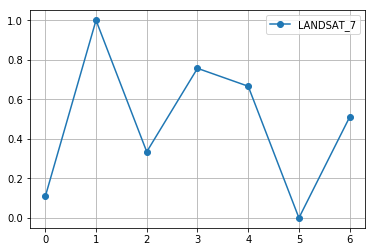

In [25]:
# Box and whisker plot for an area analysis.
if not point_analysis:
    data = [ndvi[platform].ndvi.values.flatten() for platform in datasets_in.keys()]
    filtered_data = list(map(lambda arr: arr[~np.isnan(arr)], data))
    fig = plt.figure(1, figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.boxplot(filtered_data, labels=platforms, showfliers=False)
    plt.show()
else: # Simple time series plot for a single pixel analysis.
#     plotter.plot_band(cleaned_datasets[platform], ndvi_data_arrs[platform])
    data = ndvi[platform].ndvi.mean(dim=['latitude', 'longitude']).values
    data = plotter.impute_missing_data_1D(data)
    for platform in datasets_in.keys():
        plt.plot(data, label=platform, marker='o')
    plt.grid()
    plt.legend()
    plt.show()